In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
energy = pd.read_csv('Energy Price History - Hoja 1.csv')


##### Análisis de la información y limpieza

In [3]:
energy.head()

,Fecha,mxn kw/h
0,1/10/2018,"1,8833"
1,1/11/2018,"1,845"
2,1/12/2018,"1,5025"
3,1/1/2019,"1,5062"
4,1/2/2019,"1,4972"


In [4]:
energy['Fecha']= energy['Fecha'].str.replace('/', '-')

In [5]:
energy['mxn kw/h']= energy['mxn kw/h'].str.replace(',', '.')

In [6]:
energy['mxn kw/h'] = energy['mxn kw/h'].astype('float64')

In [7]:
energy['Fecha'] = pd.to_datetime(energy['Fecha'])

In [8]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     54 non-null     datetime64[ns]
 1   mxn kw/h  54 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 992.0 bytes


In [9]:
energy = energy.set_index('Fecha')

In [10]:
energy.head()

,mxn kw/h
Fecha,
2018-01-10,1.8833
2018-01-11,1.8450
2018-01-12,1.5025
2019-01-01,1.5062
2019-01-02,1.4972


In [11]:
energy.tail()

,mxn kw/h
Fecha,
2022-11-26,1.6368
2022-12-27,1.6368
2023-01-27,1.6403
2023-02-27,1.6543
2023-03-30,1.6812


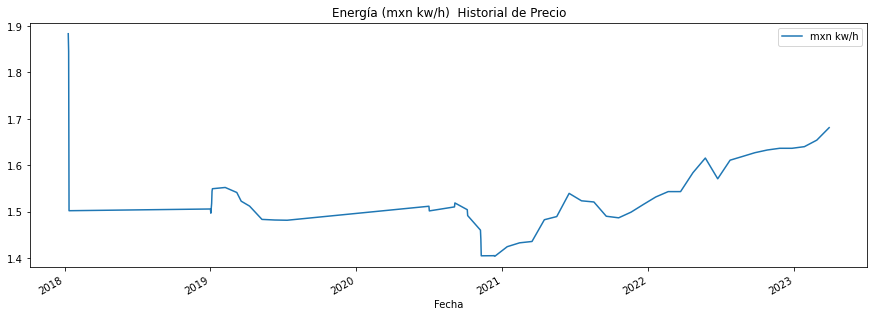

In [12]:
energy.plot(figsize=(15, 5),title='Energía (mxn kw/h)  Historial de Precio')
plt.show()

In [13]:
energy1=energy.copy()

##### Entrenamiento de los datos

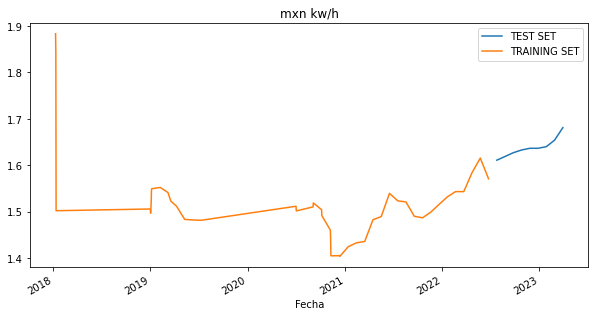

In [14]:
split_date = '7-Jul-2022'
energy1_train = energy1.loc[energy1.index <= split_date].copy()
energy1_test = energy1.loc[energy1.index > split_date].copy()

# Plot train and test so you can see where we have split
energy1_test \
    .rename(columns={'mxn kw/h': 'TEST SET'}) \
    .join(energy1_train.rename(columns={'mxn kw/h': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='mxn kw/h', ms=1)
plt.show()

In [15]:
energy1_train_prophet = energy1_train.reset_index() \
    .rename(columns={'Fecha':'ds',
                     'mxn kw/h':'y'})

In [16]:
energy1_train_prophet

,ds,y
0,2018-01-10,1.8833
1,2018-01-11,1.8450
2,2018-01-12,1.5025
3,2019-01-01,1.5062
4,2019-01-02,1.4972
5,2019-03-19,1.5230
6,2019-01-04,1.5182
7,2019-01-05,1.5444
8,2019-01-06,1.5498
9,2019-02-07,1.5525


In [17]:
model = Prophet()
model.fit(energy1_train_prophet)

16:05:02 - cmdstanpy - INFO - Chain [1] start processing
16:05:03 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
energy1_test_prophet = energy1_test.reset_index() \
    .rename(columns={'Fecha':'ds',
                     'mxn kw/h':'y'})

energy1_test_fcst = model.predict(energy1_test_prophet)

In [19]:
energy1_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-25,1.568763,1.447559,1.546656,1.568409,1.569083,-0.072591,-0.072591,-0.072591,-0.018393,-0.018393,-0.018393,-0.054198,-0.054198,-0.054198,0.0,0.0,0.0,1.496172
1,2022-08-25,1.574658,1.618312,1.725574,1.573381,1.575778,0.097778,0.097778,0.097778,0.035539,0.035539,0.035539,0.062239,0.062239,0.062239,0.0,0.0,0.0,1.672436
2,2022-09-25,1.580553,1.534887,1.641571,1.578030,1.582947,0.005204,0.005204,0.005204,0.008932,0.008932,0.008932,-0.003729,-0.003729,-0.003729,0.0,0.0,0.0,1.585757
3,2022-10-26,1.586448,1.531150,1.634768,1.582362,1.590318,-0.005316,-0.005316,-0.005316,0.041174,0.041174,0.041174,-0.046490,-0.046490,-0.046490,0.0,0.0,0.0,1.581132
4,2022-11-26,1.592343,1.555201,1.665166,1.586392,1.597971,0.016681,0.016681,0.016681,0.013218,0.013218,0.013218,0.003464,0.003464,0.003464,0.0,0.0,0.0,1.609024


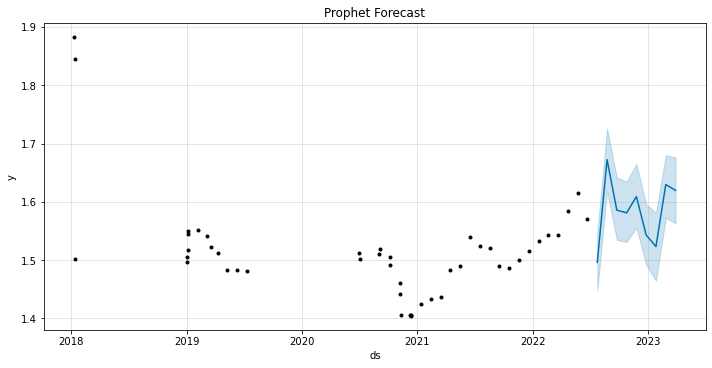

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(energy1_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

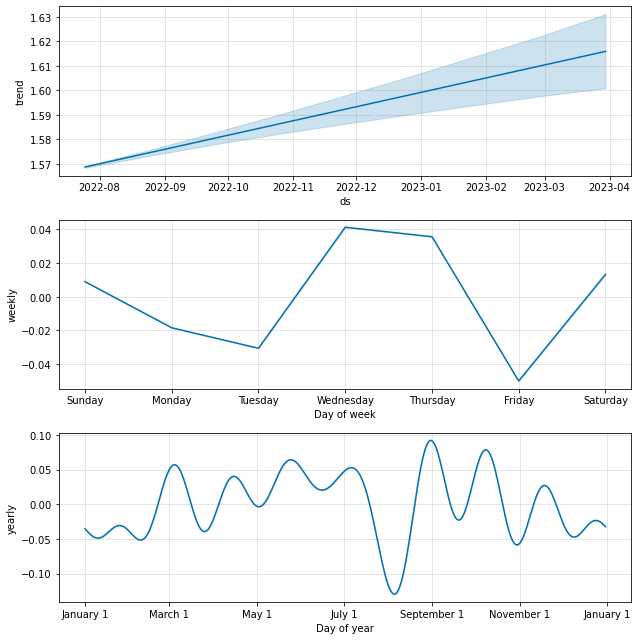

In [21]:
fig = model.plot_components(energy1_test_fcst)
plt.show()

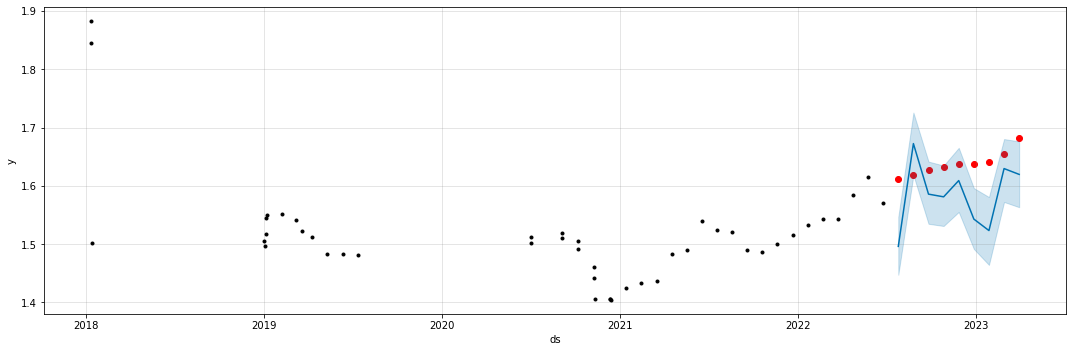

In [22]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(energy1_test.index, energy1_test['mxn kw/h'], color='r')
fig = model.plot(energy1_test_fcst, ax=ax)

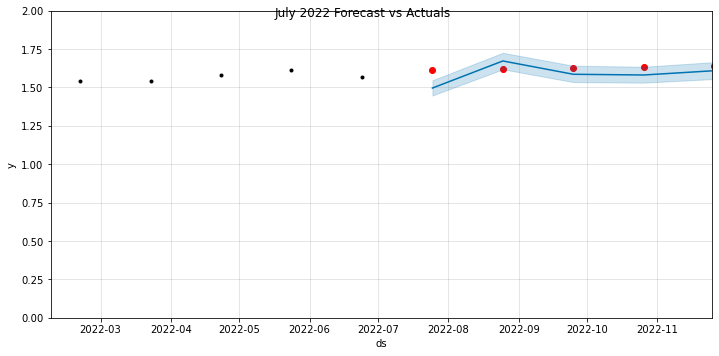

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(energy1_test.index, energy1_test['mxn kw/h'], color='r')
fig = model.plot(energy1_test_fcst, ax=ax)
ax.set_xbound(lower='02-07-2022',
              upper='25-11-2022')
ax.set_ylim(0, 2)
plot = plt.suptitle('July 2022 Forecast vs Actuals')

In [24]:
np.sqrt(mean_squared_error(y_true=energy1_test['mxn kw/h'],
                   y_pred=energy1_test_fcst['yhat']))

0.07314909924703808

In [25]:
mean_absolute_error(y_true=energy1_test['mxn kw/h'],
                   y_pred=energy1_test_fcst['yhat'])

0.06518408866179895

In [26]:
# Calculates MAPE given y_true and y_pred
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mean_absolute_percentage_error(y_true=energy1_test['mxn kw/h'],
                   y_pred=energy1_test_fcst['yhat'])

3.986680363536041

In [28]:
future = model.make_future_dataframe(periods=365, include_history=False)

In [29]:
forecast_energy = model.predict(future)

In [30]:
forecast_energy.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
360,2023-06-20,1.631516,1.569525,1.686508,1.609650,1.654396,-0.007674,-0.007674,-0.007674,-0.030539,-0.030539,-0.030539,0.022866,0.022866,0.022866,0.0,0.0,0.0,1.623843
361,2023-06-21,1.631707,1.641797,1.757091,1.609724,1.654735,0.065452,0.065452,0.065452,0.041174,0.041174,0.041174,0.024279,0.024279,0.024279,0.0,0.0,0.0,1.697159
362,2023-06-22,1.631897,1.639077,1.751100,1.609750,1.655016,0.061490,0.061490,0.061490,0.035539,0.035539,0.035539,0.025952,0.025952,0.025952,0.0,0.0,0.0,1.693387
363,2023-06-23,1.632087,1.552781,1.667922,1.609775,1.655296,-0.022080,-0.022080,-0.022080,-0.049930,-0.049930,-0.049930,0.027850,0.027850,0.027850,0.0,0.0,0.0,1.610007
364,2023-06-24,1.632277,1.614030,1.734887,1.609804,1.655577,0.043151,0.043151,0.043151,0.013218,0.013218,0.013218,0.029934,0.029934,0.029934,0.0,0.0,0.0,1.675428


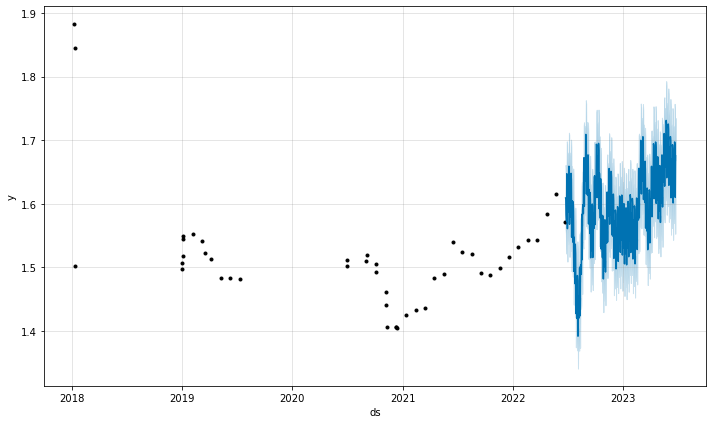

In [31]:
fig1 = model.plot(forecast_energy)

In [32]:
filename = 'forecast_energy.csv'
forecast_energy.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: forecast_energy.csv
